In [2]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [4]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[2.2119],
         [0.5217]]),
 tensor([[1.0000e+00, 2.2119e+00, 2.4462e+00, 1.8035e+00, 9.9730e-01, 4.4118e-01,
          1.6264e-01, 5.1391e-02, 1.4209e-02, 3.4920e-03, 7.7238e-04, 1.5531e-04,
          2.8627e-05, 4.8707e-06, 7.6953e-07, 1.1347e-07, 1.5687e-08, 2.0410e-09,
          2.5080e-10, 2.9197e-11],
         [1.0000e+00, 5.2165e-01, 1.3606e-01, 2.3659e-02, 3.0854e-03, 3.2191e-04,
          2.7987e-05, 2.0857e-06, 1.3600e-07, 7.8827e-09, 4.1121e-10, 1.9501e-11,
          8.4772e-13, 3.4016e-14, 1.2675e-15, 4.4079e-17, 1.4371e-18, 4.4099e-20,
          1.2780e-21, 3.5089e-23]]),
 tensor([9.4100, 5.3834]))

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.013238   1.1806877 -3.402134   5.630388 ]]


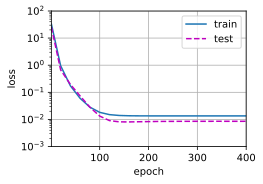

In [7]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.618386 4.923125]]


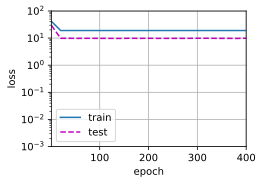

In [8]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.0233107e+00  1.2688284e+00 -3.4469419e+00  5.2062778e+00
   9.8250605e-02  1.0563504e+00  8.6646989e-02  2.4785016e-01
   2.7259129e-01 -9.2875428e-02 -1.7489462e-01  7.3363812e-04
   1.8999134e-01  7.6351807e-02  1.5576576e-01 -6.1028797e-02
  -5.0026305e-02 -5.3993538e-02 -1.1582387e-01  1.0202789e-01]]


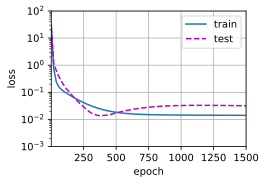

In [9]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)